In [ ]:
# Authors: Enock Niyonkuru & Digesh Chitrakar
# Class: Deep Learning
# Date:  15 May 2022
#COVID Prediction using chest X-Ray Images and Masked chest X-ray Images. 

## Downloading Dataset

In [ ]:
## Get Username and Key to Download Dataset from Kaggle
! echo '{"username":"digeshchitrakar","key":"dafc1c5e331a1c844bc04a0ac2a3c5d9"}' >> kaggle.json

In [ ]:
## Set up kaggle files
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
## Download Dataset
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 99% 768M/778M [00:03<00:00, 226MB/s]
100% 778M/778M [00:03<00:00, 249MB/s]


In [ ]:
## Unzip Dataset
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
## Setting up directories for Different Tests

# Training and Testing on just Images
! mkdir -p /content/dataset_image/train/COVID
! mkdir -p /content/dataset_image/train/Normal
! mkdir -p /content/dataset_image/test/COVID
! mkdir -p /content/dataset_image/test/Normal

# Training and Testing on just masks
! mkdir -p /content/dataset_mask/train/COVID
! mkdir -p /content/dataset_mask/train/Normal
! mkdir -p /content/dataset_mask/test/COVID
! mkdir -p /content/dataset_mask/test/Normal

# Training and Testing on both images and masks
! mkdir -p /content/dataset_all/train/COVID
! mkdir -p /content/dataset_all/train/Normal
! mkdir -p /content/dataset_all/test/COVID
! mkdir -p /content/dataset_all/test/Normal

In [ ]:
## Copying images from downloaded dataset to separate tests
# Different Labels
typ = ['Normal', 'COVID']
import os

for t in typ:
    source1 = '/content/COVID-19_Radiography_Dataset/' + t
    dest1 = '/content/dataset_image/train/' + t
    dest2 = '/content/dataset_image/test/' + t
    files = os.listdir(source1+'/images')
    import shutil
    import numpy as np
    for f in files:
        if np.random.rand(1) < 0.8:
            shutil.copy(source1 + '/images/'+ f, dest1 +'/'+ f)
        else:
            shutil.copy(source1 + '/images/'+ f, dest2 +'/'+ f)

for t in typ:
    source1 = '/content/COVID-19_Radiography_Dataset/' + t
    dest1 = '/content/dataset_mask/train/' + t
    dest2 = '/content/dataset_mask/test/' + t
    files = os.listdir(source1+'/masks')
    import shutil
    import numpy as np
    for f in files:
        if np.random.rand(1) < 0.8:
            shutil.copy(source1 + '/masks/'+ f, dest1 +'/'+ f)
        else:
            shutil.copy(source1 + '/masks/'+ f, dest2 +'/'+ f)

for t in typ:
    source1 = '/content/COVID-19_Radiography_Dataset/' + t
    dest1 = '/content/dataset_all/train/' + t
    dest2 = '/content/dataset_all/test/' + t
    files = os.listdir(source1+'/masks')
    import shutil
    import numpy as np
    for f in files:
        if np.random.rand(1) < 0.8:
            shutil.copy(source1 + '/images/'+ f, dest1 +'/i_'+ f)
            shutil.copy(source1 + '/masks/'+ f, dest1 +'/_m'+ f)
        else:
            shutil.copy(source1 + '/images/'+ f, dest2 +'/_i'+ f)
            shutil.copy(source1 + '/masks/'+ f, dest2 +'/_m'+ f)

## Setting up Model

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
# Get different metrics for predictions
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def my_metric_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [ ]:
# Test Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as keras
import tensorflow as tf


def test_model(pretrained_weights = None,input_size = (300,300,3)):

    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_size, padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy',f1_m,precision_m, recall_m])
    
    return model





## Train and Test on Image and Masks

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 16 using train_datagen generator
image_generator = train_datagen.flow_from_directory(
        '/content/dataset_all/train',  # This is the source directory for training images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300), 
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

train_generator =  image_generator

validation_datagen = ImageDataGenerator(rescale=1/255)

val_image_generator = validation_datagen.flow_from_directory(
        '/content/dataset_all/test',  # This is the source directory for testing images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

validation_generator = val_image_generator



Found 22088 images belonging to 2 classes.
Found 5528 images belonging to 2 classes.


In [ ]:
num_test = len(os.listdir('/content/dataset_all/test/COVID')) + len(os.listdir('/content/dataset_all/test/Normal'))

In [ ]:
model = test_model()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 128)      0

In [ ]:
model_checkpoint = ModelCheckpoint('lungs_all.hdf5', monitor = 'loss', callbacks = [monitor], verbose=1, save_best_only=True)

In [ ]:
history_all = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=400,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/400
8/8 [==============================] - 18s 303ms/step - loss: 0.6764 - accuracy: 0.7188 - f1_m: 0.7490 - precision_m: 0.7054 - recall_m: 0.8304 - val_loss: 0.6494 - val_accuracy: 0.7500 - val_f1_m: 0.8516 - val_precision_m: 0.7500 - val_recall_m: 1.0000
Epoch 2/400
8/8 [==============================] - 2s 185ms/step - loss: 0.6336 - accuracy: 0.7266 - f1_m: 0.8386 - precision_m: 0.7266 - recall_m: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.7969 - val_f1_m: 0.8786 - val_precision_m: 0.7969 - val_recall_m: 1.0000
Epoch 3/400
8/8 [==============================] - 1s 148ms/step - loss: 0.5779 - accuracy: 0.7344 - f1_m: 0.8414 - precision_m: 0.7344 - recall_m: 1.0000 - val_loss: 0.5002 - val_accuracy: 0.7969 - val_f1_m: 0.8789 - val_precision_m: 0.7969 - val_recall_m: 1.0000
Epoch 4/400
8/8 [==============================] - 1s 98ms/step - loss: 0.6034 - accuracy: 0.7344 - f1_m: 0.8435 - precision_m: 0.7344 - recall_m: 1.0000 - val_loss: 0.5879 - val_accuracy: 0.7344 - val_f1

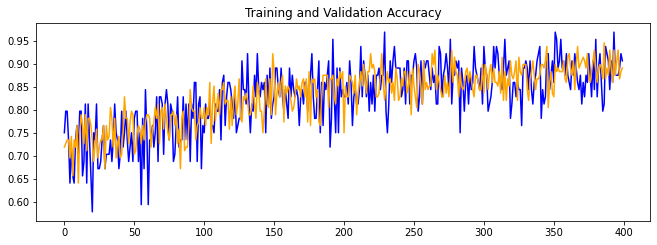

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_all.history['accuracy']
val_acc=history_all.history['val_accuracy']
loss=history_all.history['loss']
val_loss=history_all.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(211)
plt.title('Training and Validation Accuracy')
plt.plot(val_acc, color='blue', label='test')
plt.plot(acc, color='orange', label='train')



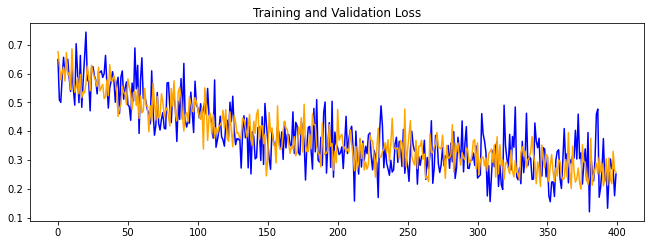

In [ ]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(212)
plt.title('Training and Validation Loss')
plt.plot(val_loss, color='blue', label='test')
plt.plot(loss, color='orange', label='train')


In [ ]:
loss_all, accuracy_all, f1_score_all, precision_all, recall_all = model.evaluate_generator(validation_generator, num_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print('On both Image and Mask:')
print('loss: ' + str(loss_all))
print('accuracy: ' + str(accuracy_all))
print('f1_score: ' + str(f1_score_all))
print('precision: ' + str(precision_all))
print('recall: ' + str(recall_all))

On both Image and Mask:
loss: 0.28481221199035645
accuracy: 0.8889299035072327
f1_score: 0.9184744954109192
precision: 0.9073079228401184
recall: 0.9417486786842346


## Train and Test on Image only

In [ ]:
# Flow training images in batches of 128 using train_datagen generator
train_datagen = ImageDataGenerator(rescale=1/255)


image_generator = train_datagen.flow_from_directory(
        '/content/dataset_image/train',  # This is the source directory for training images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

train_generator =  image_generator

validation_datagen = ImageDataGenerator(rescale=1/255)

val_image_generator = validation_datagen.flow_from_directory(
        '/content/dataset_image/test',  # This is the source directory for testing images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

validation_generator = val_image_generator

Found 11079 images belonging to 2 classes.
Found 2729 images belonging to 2 classes.


In [ ]:
num_test = len(os.listdir('/content/dataset_image/test/COVID')) + len(os.listdir('/content/dataset_image/test/Normal'))

In [ ]:
model = test_model()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model_checkpoint = ModelCheckpoint('lungs_images.hdf5', monitor = 'loss', callbacks = [monitor], verbose=1, save_best_only=True)

In [ ]:
history_image = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=400,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/400
8/8 [==============================] - 2s 150ms/step - loss: 0.6918 - accuracy: 0.5938 - f1_m: 0.5893 - precision_m: 0.6371 - recall_m: 0.6181 - val_loss: 0.6833 - val_accuracy: 0.7344 - val_f1_m: 0.8354 - val_precision_m: 0.7344 - val_recall_m: 1.0000
Epoch 2/400
8/8 [==============================] - 1s 108ms/step - loss: 0.6706 - accuracy: 0.7109 - f1_m: 0.8287 - precision_m: 0.7109 - recall_m: 1.0000 - val_loss: 0.6642 - val_accuracy: 0.6250 - val_f1_m: 0.7581 - val_precision_m: 0.6250 - val_recall_m: 1.0000
Epoch 3/400
8/8 [==============================] - 1s 111ms/step - loss: 0.5624 - accuracy: 0.7891 - f1_m: 0.8798 - precision_m: 0.7891 - recall_m: 1.0000 - val_loss: 0.6275 - val_accuracy: 0.7344 - val_f1_m: 0.8399 - val_precision_m: 0.7344 - val_recall_m: 1.0000
Epoch 4/400
8/8 [==============================] - 1s 110ms/step - loss: 0.5306 - accuracy: 0.7969 - f1_m: 0.8842 - precision_m: 0.7969 - recall_m: 1.0000 - val_loss: 0.4950 - val_accuracy: 0.8125 - val_f1

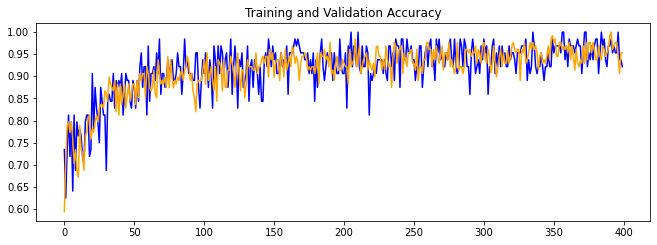

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_image.history['accuracy']
val_acc=history_image.history['val_accuracy']
loss=history_image.history['loss']
val_loss=history_image.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(211)
plt.title('Training and Validation Accuracy')
plt.plot(val_acc, color='blue', label='test')
plt.plot(acc, color='orange', label='train')


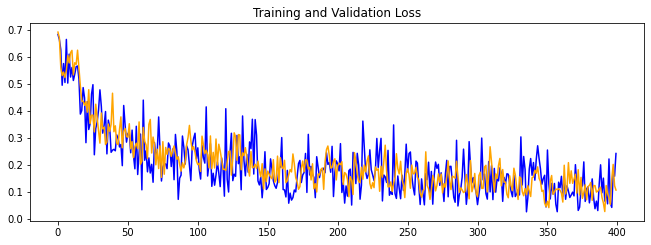

In [ ]:

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(212)
plt.title('Training and Validation Loss')
plt.plot(val_loss, color='blue', label='test')
plt.plot(loss, color='orange', label='train')


In [ ]:
loss_image, accuracy_image, f1_score_image, precision_image, recall_image = model.evaluate_generator(validation_generator, num_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print('On Image:')
print('loss: ' + str(loss_image))
print('accuracy: ' + str(accuracy_image))
print('f1_score: ' + str(f1_score_image))
print('precision: ' + str(precision_image))
print('recall: ' + str(recall_image))

On Image:
loss: 0.14579471945762634
accuracy: 0.9486808776855469
f1_score: 0.9595434665679932
precision: 0.9732728004455566
recall: 0.9530864357948303


## Train and Test on Mask only

In [ ]:
# Flow training images in batches of 16 using train_datagen generator
train_datagen = ImageDataGenerator(rescale=1/255)

image_generator = train_datagen.flow_from_directory(
        '/content/dataset_mask/train',  # This is the source directory for training images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

train_generator =  image_generator

validation_datagen = ImageDataGenerator(rescale=1/255)

val_image_generator = validation_datagen.flow_from_directory(
        '/content/dataset_mask/test',  # This is the source directory for training images
        classes = ['COVID', 'Normal'],
        target_size=(300, 300),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        seed = 42)

validation_generator = val_image_generator

Found 10990 images belonging to 2 classes.
Found 2818 images belonging to 2 classes.


In [ ]:
num_test = len(os.listdir('/content/dataset_mask/test/COVID')) + len(os.listdir('/content/dataset_mask/test/Normal'))

In [ ]:
model = test_model()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model_checkpoint = ModelCheckpoint('lungs_masks.hdf5', monitor = 'loss', callbacks = [monitor], verbose=1, save_best_only=True)

In [ ]:
history_mask = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=400,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/400
8/8 [==============================] - 2s 137ms/step - loss: 0.6429 - accuracy: 0.7344 - f1_m: 0.8436 - precision_m: 0.7344 - recall_m: 1.0000 - val_loss: 0.5557 - val_accuracy: 0.7656 - val_f1_m: 0.8533 - val_precision_m: 0.7656 - val_recall_m: 1.0000
Epoch 2/400
8/8 [==============================] - 1s 92ms/step - loss: 0.5177 - accuracy: 0.7891 - f1_m: 0.8790 - precision_m: 0.7891 - recall_m: 1.0000 - val_loss: 0.5868 - val_accuracy: 0.7500 - val_f1_m: 0.8527 - val_precision_m: 0.7500 - val_recall_m: 1.0000
Epoch 3/400
8/8 [==============================] - 1s 91ms/step - loss: 0.6147 - accuracy: 0.7109 - f1_m: 0.8262 - precision_m: 0.7109 - recall_m: 1.0000 - val_loss: 0.5950 - val_accuracy: 0.7188 - val_f1_m: 0.8304 - val_precision_m: 0.7188 - val_recall_m: 1.0000
Epoch 4/400
8/8 [==============================] - 1s 90ms/step - loss: 0.6065 - accuracy: 0.7266 - f1_m: 0.8389 - precision_m: 0.7266 - recall_m: 1.0000 - val_loss: 0.5573 - val_accuracy: 0.7969 - val_f1_m:

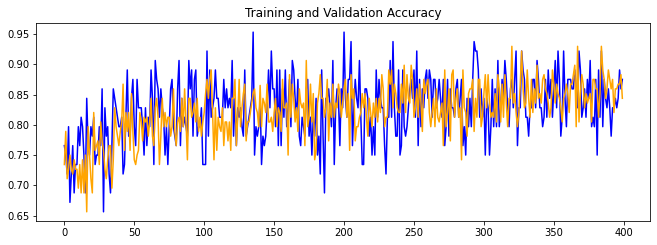

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_mask.history['accuracy']
val_acc=history_mask.history['val_accuracy']
loss=history_mask.history['loss']
val_loss=history_mask.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(211)
plt.title('Training and Validation Accuracy')
plt.plot(val_acc, color='blue', label='test')
plt.plot(acc, color='orange', label='train')



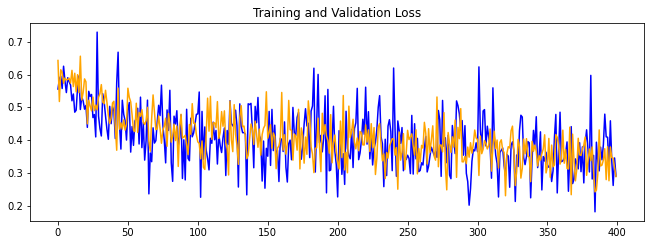

In [ ]:

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize = (11, 8))
plt.subplot(212)
plt.title('Training and Validation Loss')
plt.plot(val_loss, color='blue', label='test')
plt.plot(loss, color='orange', label='train')

In [ ]:
loss_mask, accuracy_mask, f1_score_mask, precision_mask, recall_mask = model.evaluate_generator(validation_generator, num_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print('On both Image:')
print('loss: ' + str(loss_mask))
print('accuracy: ' + str(accuracy_mask))
print('f1_score: ' + str(f1_score_mask))
print('precision: ' + str(precision_mask))
print('recall: ' + str(recall_mask))

On both Image:
loss: 0.36340466141700745
accuracy: 0.8442157506942749
f1_score: 0.8899864554405212
precision: 0.8728890419006348
recall: 0.9244065880775452
